In [5]:
# Load paths
path_to_features = f"/rds/projects/s/subramaa-mum-predict/CharlesGadd_Oxford/MumPredictPreprocessing/disease_profiles.csv"  
# Save paths
path_to_model = f"/rds/projects/s/subramaa-mum-predict/CharlesGadd_Oxford/mmVAE_MentalHealthOutputs/" 
path_to_figs = path_to_model + 'plots/'

import os
os.chdir('/rds/homes/g/gaddcz/Projects/mum-predict-repos/mmVAE/src/')

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from experiment import fit_restarts
from plot_wrappers import plot_restarts
import helpers

torch.manual_seed(0)
np.random.seed(0)
%matplotlib inline

# Load CPRD data
Here we load the CPRD data from outside the repository. 
We then re-order the the columns (which won't affect modelling) to  aid visualisation later. 
Finally we remove non-multimorbidity cases (with fewer than 2 conditions)

In [6]:
diag_frame = pd.read_csv(path_to_features)[helpers.get_column_order()]

# Remove some additional samples - these are patients with only one condition at the randomly selected pregnancy.
# print(np.where(diag_frame.sum(axis = 1) < 2)[0])        
np.savetxt("/rds/projects/s/subramaa-mum-predict/CharlesGadd_Oxford/MumPredictPreprocessing/mm_cases.txt", np.where(diag_frame.sum(axis = 1) >= 2)[0])
diag_frame = diag_frame[diag_frame.sum(axis = 1) >= 2]

diag_frame.columns = helpers.get_column_order(plot=True)
diag_frame.reset_index(level=None, drop=True, inplace=True, col_level=0, col_fill='')

N = diag_frame.shape[0]
D = diag_frame.shape[1]

# Check prevalence of diseases
print(list(zip(diag_frame.columns, diag_frame.to_numpy().sum(axis=0))))

print(f"\n We have {N} training samples, and {D} conditions")


[('Cancer', 2890), ('Asthma', 85395), ('Female infertility', 24125), ('Allergic Rhin Conj', 92404), ('Migraine', 64686), ('Anxiety', 97255), ('Depression', 133090), ('Substance misuse', 11638), ('Alcohol problem', 5683), ('Eating disorder', 11645), ('SMHmm', 11108), ('Other mental', 47124), ('Other headache', 23626), ('AdrenalAll', 62), ('Pituitary', 2010), ('PCOS', 21012), ('Sarcoid', 292), ('Leiomyoma', 3338), ('Endometriosis', 10507), ('Retinal detachment', 473), ('PTH', 134), ('Heart failure', 383), ('IHD/MI', 664), ('Stroke', 1010), ('Interstitial lung', 50), ('Blind', 118), ('COPD', 323), ('Solid organ transplant', 181), ('Bronchiectasis', 382), ('Neuro development', 2542), ('Atopic eczema', 16581), ('Cardiomyopathy', 207), ('Cystic fybrosis', 239), ('Sickle cell', 119), ('Pulminary Heart', 45), ('IBS', 49439), ('Turners syndrome', 57), ('Marfan syndrome', 125), ('HIV', 267), ('Diabetes', 5071), ('Diabetes (retino)', 1720), ('Hypertension', 6876), ('Spina bifida', 644), ('Congeni

# Run experiment

Plot order
* the prevalence of each condition in each quantised cluster
* the log odds ratio of each quantised cluster
* the cluster factor association matrix
* the prevalence within factors
* the log odds ratio within factors


Failed to load /rds/projects/s/subramaa-mum-predict/CharlesGadd_Oxford/mmVAE_MentalHealthOutputs/Bernoulli_BetaNeg0_40_0.pickle, training...
====> Training Epoch: 1 Train loss: 6.856 (Reconstruction loss:6.85550 and entropy:9.34441). Temperature 4.0. kl_anneal: 0.00
	====> Validating: Validation loss: 19.416 (Reconstruction loss:2.61399 and entropy: 7.97573). Temperature 0.4. kl_anneal: 1
====> Training Epoch: 2 Train loss: 2.225 (Reconstruction loss:2.22519 and entropy:6.42997). Temperature 3.8. kl_anneal: 0.00
====> Training Epoch: 3 Train loss: 1.861 (Reconstruction loss:1.86112 and entropy:4.63633). Temperature 3.6. kl_anneal: 0.00
====> Training Epoch: 4 Train loss: 1.672 (Reconstruction loss:1.67249 and entropy:3.68496). Temperature 3.5. kl_anneal: 0.00
====> Training Epoch: 5 Train loss: 1.571 (Reconstruction loss:1.57131 and entropy:3.13512). Temperature 3.3. kl_anneal: 0.00
====> Training Epoch: 6 Train loss: 1.506 (Reconstruction loss:1.50578 and entropy:2.83928). Temperature

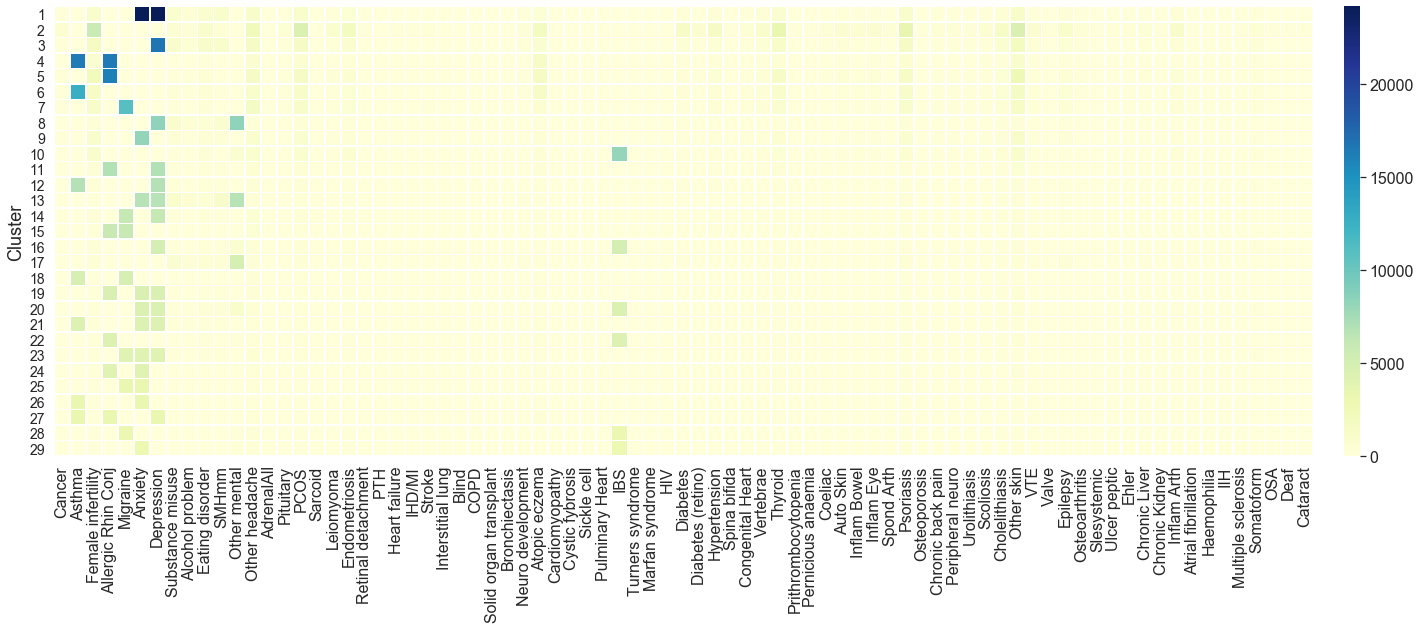

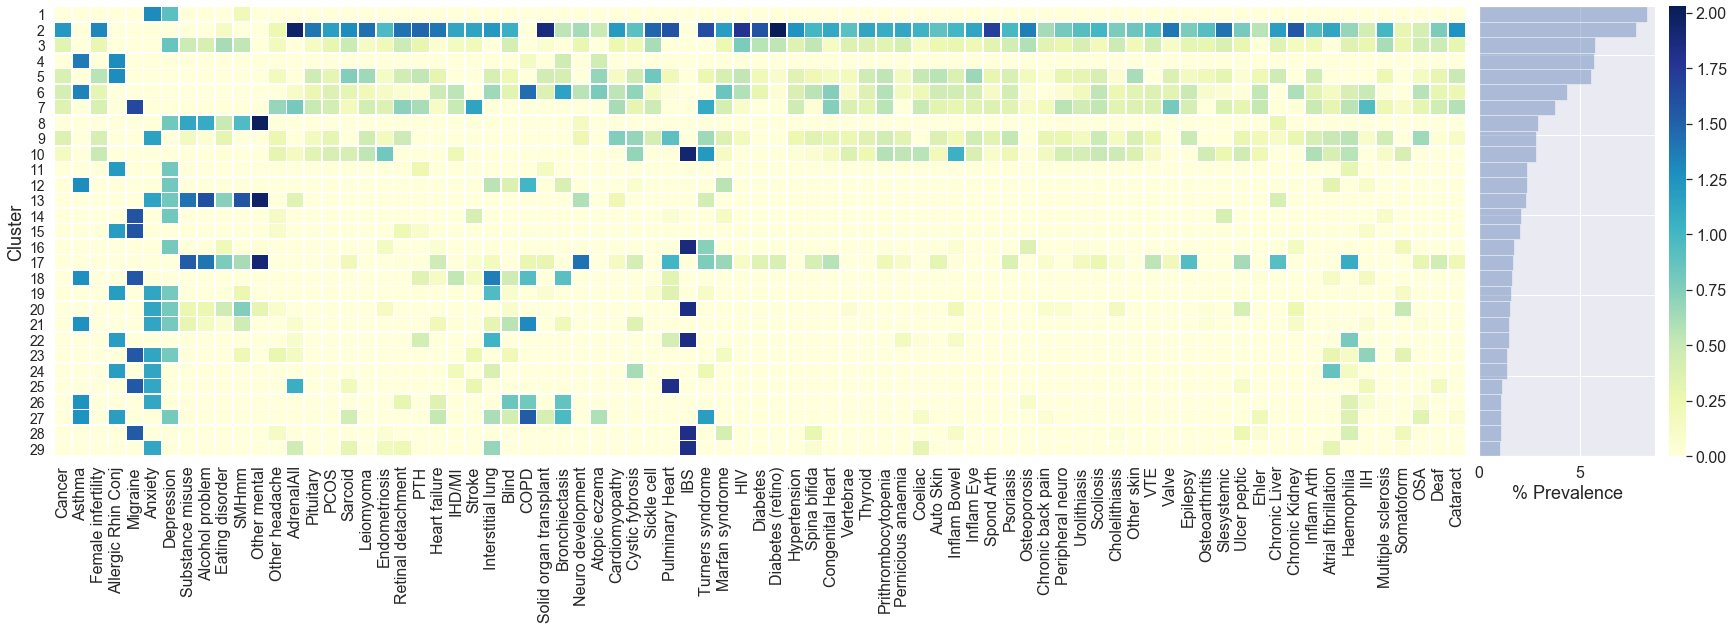

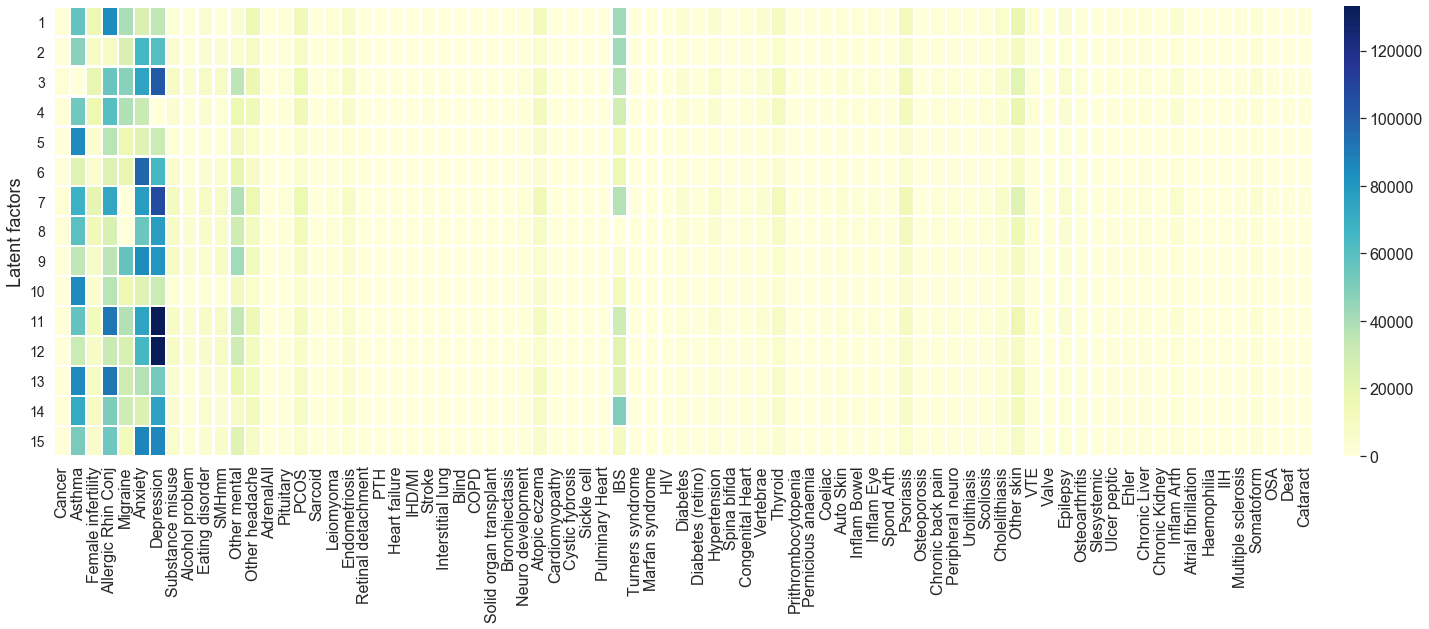

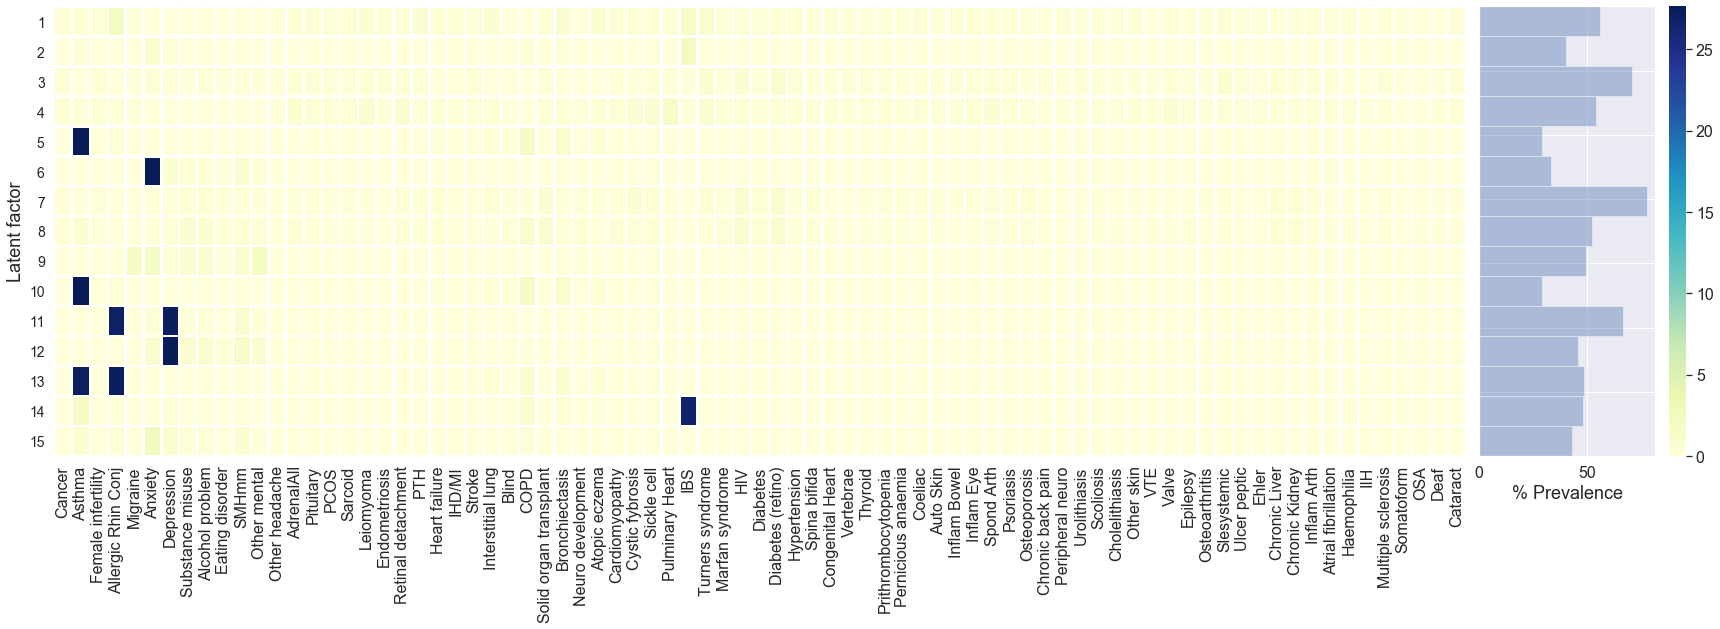

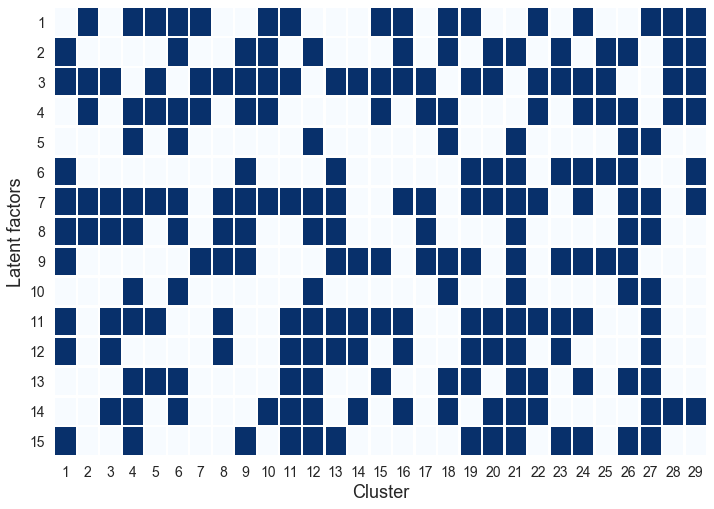

Saving best seed clustering at /rds/projects/s/subramaa-mum-predict/CharlesGadd_Oxford/mmVAE_MentalHealthOutputs/Bernoulli_BetaNeg0_40_1




In [7]:
for L in [15]:
    architecture = {'enc_h': [D, D, D, L], 
                    'dec_h': [L, D, D, D], 
                    'constrain': ['L0', 'L0'],
                   }
    model_params = {'tmp_schedule': [4, 0.4, 0.4],
                     'epochs': 50,
                     'batch_size': 1024,
                     'lr': 1e-3,
                     'verbose': 1,
                     'anneal': True,
                     'norm_beta': -0.4
                    }



    method_name = f'Bernoulli_Beta{model_params["norm_beta"]:.2f}'.replace(".", "_").replace("-", "Neg")

    all_dicts, losses, labels, avg_ami = fit_restarts(diag_frame, architecture, model_params,
                                                      n_restarts=3,
                                                      save_path=f"{path_to_model}{method_name}",
                                                      force_retrain=False
                                                     )

    best_dict, best_path = plot_restarts(diag_frame, all_dicts, losses, labels,
                                         Y_test=None, 
                                         yaxis_scale=1, plot_threshold_frac=0.01, 
                                         save_path=f"{path_to_model}{method_name}",
                                         plot_path=f"{path_to_figs}{method_name}",
                                         log_odds=True, vmin=0, vmax=None,
                                        )

    print(f"Saving best seed clustering at {best_path}\n\n")
    np.savetxt(best_path + "cluster_allocations.txt", best_dict['cluster_allocations'])
    np.savetxt(best_path + "z_binary.txt", best_dict['z_binary'])
